In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tlo import Date
from tlo.analysis.utils import (
    extract_results,
    summarize,
)
import matplotlib.dates as mdates

import geopandas as gpd

In [2]:
results_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

output_folder = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

In [3]:
climate_sensitivity_analysis = False
main_text = True
parameter_uncertainty_analysis = False

if parameter_uncertainty_analysis:
    scenario_names = range(0,  200, 1)
    scenarios_of_interest = scenario_names
    suffix = "parameter_UA"
if main_text:
    scenario_names = [
        "Baseline",
        "Best Case",
        "Worst Case"
    ]
    suffix = "main_text"
    scenarios_of_interest = [0, 1, 2]


In [4]:

min_year = 2025
max_year = 2041
spacing_of_years = 1


Helper functions

In [5]:
target_year_sequence = range(min_year, max_year, spacing_of_years)

# Define the extraction functions (add these near your other helper functions)
def get_num_treatments_total_delayed(_df):
    """Count total number of delayed HSI events"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    print(_df)
    return pd.Series(len(_df), name="total")

def get_num_treatments_total_cancelled(_df):
    """Count total number of cancelled HSI events"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    return pd.Series(len(_df), name="total")

def get_num_treatments_total(_df):
    """Sum all treatment counts"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    total = {}
    for d in _df["hsi_event_key_to_counts"]:
        for k, v in d.items():
            total[k] = total.get(k, 0) + v
    print(sum(total.values()))
    return pd.Series(sum(total.values()), name="total")

def get_num_dalys_total(_df):
        """Return total number of DALYS (Stacked) by label (total by age-group within the TARGET_PERIOD)
        """
        return pd.Series(_df \
            .loc[_df.year.between(*[i.year for i in TARGET_PERIOD])] \
            .drop(columns=['date', 'sex', 'age_range', 'year']) \
            .sum().sum(), name="total")

def get_num_dalys_by_month(_df):
    """Sum all DALYs across all causes by month for the target year"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    # Sum across all disease columns (excluding non-disease columns)
    disease_columns = [col for col in _df.columns
                      if col not in ['age_range', 'month', 'sex', 'year', 'date']]

    # Group by month and sum
    monthly_dalys = _df.groupby('month')[disease_columns].sum().sum(axis=1)

    return monthly_dalys

def get_population_for_year(_df):
        """Returns the population in the year of interest"""
        _df["date"] = pd.to_datetime(_df["date"])

        # Filter the DataFrame based on the target period
        filtered_df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
        numeric_df = filtered_df.drop(columns=["female", "male"], errors="ignore")
        population_sum = numeric_df.sum(numeric_only=True)

        return population_sum



 Save results

# BEST/WORST CASE


In [16]:

results_folder_baseline = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/baseline_run_with_pop-2026-02-05T113912Z')


# Helper functions
def get_hsi_counts_by_facility_monthly(_df):
    """Get HSI counts by facility_id and month"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    if len(_df) == 0:
        return pd.Series(dtype=int)

    # Create keys like "2010-02_128" (month_facilityID)
    facility_month_totals = {}
    for _, row in _df.iterrows():
        month_key = row['date'].strftime('%Y-%m')
        counts_dict = row['counts']

        for key, value in counts_dict.items():
            if ':' in key:
                facility_id, _ = key.split(':', 1)
                facility_month_totals[facility_id] = facility_month_totals.get(facility_id, 0) + value

    return pd.Series(facility_month_totals)
def get_num_treatments_by_facility_delayed(_df):
    """Count number of delayed HSI events by facility"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="delayed_count")
    
    # Group by Facility_ID and count
    delayed_by_facility = _df.groupby('Facility_ID').size()
    delayed_by_facility.name = 'delayed_count'
    
    return delayed_by_facility


def get_num_treatments_by_facility_cancelled(_df):
    """Count number of cancelled HSI events by facility"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="cancelled_count")
    
    # Group by Facility_ID and count
    cancelled_by_facility = _df.groupby('Facility_ID').size()
    cancelled_by_facility.name = 'cancelled_count'
    
    return cancelled_by_facility

# Storage dictionaries
all_scenarios_appointment_delayed_mean = {}
all_scenarios_appointment_cancelled_mean = {}
all_scenarios_dalys_mean = {}
# Main loop
for draw in range(len(scenarios_of_interest)):
    print(draw)
    all_years_data_delayed_mean = {}
    all_years_data_cancelled_mean = {}
    all_years_dalys_mean = {}
    baseline_hsi_by_facility = {}
    
    for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

        # Get baseline HSI by facility (sum across months to get yearly total per facility)
        hsi_by_facility = summarize(extract_results(
                    results_folder_baseline,
                    module='tlo.methods.healthsystem.summary',
                    key='hsi_event_counts_by_facility_monthly',
                    custom_generate_series=get_hsi_counts_by_facility_monthly,
                    do_scaling=False
                ), only_mean=True, collapse_columns=False)[draw]
        
        # Sum across months to get total by facility for the year
        hsi_by_facility.index = pd.Index([int(x) for x in hsi_by_facility.index], name='Facility_ID')

        baseline_hsi_by_facility[target_year] = hsi_by_facility

        if draw in [0]:
            all_years_data_delayed_mean[target_year] = pd.Series([0], name='mean')
            all_years_data_cancelled_mean[target_year] = pd.Series([0], name='mean')
        else:
            # Get delayed counts BY FACILITY
            num_delayed_by_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_delayed_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_delayed,  
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Get cancelled counts BY FACILITY
            num_cancelled_by_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_cancelled_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_cancelled,  
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]


            baseline_aligned, delayed_aligned = baseline_hsi_by_facility[target_year].align(num_delayed_by_facility, fill_value=0)
            delayed_proportions = delayed_aligned / baseline_aligned
            
            baseline_aligned, cancelled_aligned = baseline_hsi_by_facility[target_year].align(num_cancelled_by_facility, fill_value=0)
            cancelled_proportions = cancelled_aligned / baseline_aligned
            
            
            all_years_data_delayed_mean[target_year] = delayed_proportions
            all_years_data_cancelled_mean[target_year] = cancelled_proportions
            

    all_scenarios_appointment_delayed_mean[draw] = all_years_data_delayed_mean
    all_scenarios_appointment_cancelled_mean[draw] = all_years_data_cancelled_mean
    all_scenarios_dalys_mean[draw] = all_years_dalys_mean

0


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

1


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

2


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

In [20]:
# Now only those reporting disruptions
# Storage dictionaries
all_scenarios_appointment_delayed_mean = {}
all_scenarios_appointment_cancelled_mean = {}
all_scenarios_dalys_mean = {}

# Main loop
for draw in range(len(scenarios_of_interest)):
    print(draw)
    all_years_data_delayed_mean = {}
    all_years_data_cancelled_mean = {}
    all_years_dalys_mean = {}
    baseline_hsi_by_facility = {}
    
    for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

        # Get baseline HSI by facility (sum across months to get yearly total per facility)
        hsi_by_facility = summarize(extract_results(
                    results_folder_baseline,
                    module='tlo.methods.healthsystem.summary',
                    key='hsi_event_counts_by_facility_monthly',
                    custom_generate_series=get_hsi_counts_by_facility_monthly,
                    do_scaling=False
                ), only_mean=True, collapse_columns=False)[draw]
        
        # Sum across months to get total by facility for the year
        hsi_by_facility.index = pd.Index([int(x) for x in hsi_by_facility.index], name='Facility_ID')

        baseline_hsi_by_facility[target_year] = hsi_by_facility

        if draw in [0]:
            all_years_data_delayed_mean[target_year] = pd.Series([0], name='mean')
            all_years_data_cancelled_mean[target_year] = pd.Series([0], name='mean')
        else:
            # Get delayed counts BY FACILITY
            num_delayed_by_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_delayed_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_delayed,  
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Get cancelled counts BY FACILITY
            num_cancelled_by_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_cancelled_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_cancelled,  
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Align baseline with disruption counts
            baseline_aligned, delayed_aligned = baseline_hsi_by_facility[target_year].align(
                num_delayed_by_facility, fill_value=0
            )
            baseline_aligned2, cancelled_aligned = baseline_hsi_by_facility[target_year].align(
                num_cancelled_by_facility, fill_value=0
            )
            
            # Calculate proportions for all facilities
            delayed_proportions = delayed_aligned / baseline_aligned
            cancelled_proportions = cancelled_aligned / baseline_aligned2
            
            # Identify facilities with ANY disruption (delayed OR cancelled)
            # We need to align both disruption series to get a consistent set of facilities
            delayed_aligned_full, cancelled_aligned_full = delayed_aligned.align(
                cancelled_aligned, fill_value=0
            )
            
            # Mask: facilities with at least one disruption (either type)
            has_disruption = (delayed_aligned_full > 0) | (cancelled_aligned_full > 0)
            
            # Filter to only facilities with disruptions
            facilities_with_disruption = has_disruption[has_disruption].index
            
            # Calculate proportions only for facilities with disruptions
            if len(facilities_with_disruption) > 0:
                delayed_proportions_filtered = delayed_proportions[
                    delayed_proportions.index.isin(facilities_with_disruption)
                ]
                cancelled_proportions_filtered = cancelled_proportions[
                    cancelled_proportions.index.isin(facilities_with_disruption)
                ]
            else:
                # No disruptions at all
                delayed_proportions_filtered = pd.Series(dtype=float)
                cancelled_proportions_filtered = pd.Series(dtype=float)
            
            all_years_data_delayed_mean[target_year] = delayed_proportions_filtered
            all_years_data_cancelled_mean[target_year] = cancelled_proportions_filtered
            
            print(f"  Year {target_year}: {len(facilities_with_disruption)} facilities with disruptions "
                  f"(out of {len(baseline_aligned)} total)")

    all_scenarios_appointment_delayed_mean[draw] = all_years_data_delayed_mean
    all_scenarios_appointment_cancelled_mean[draw] = all_years_data_cancelled_mean
    all_scenarios_dalys_mean[draw] = all_years_dalys_mean

0


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics

1


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2025: 37 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2026: 35 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2027: 36 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2028: 37 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2029: 37 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2030: 35 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2031: 37 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2032: 37 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2033: 37 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2034: 37 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2035: 37 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2036: 37 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2037: 37 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2038: 36 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2039: 36 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2040: 36 facilities with disruptions (out of 99 total)
2


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2025: 35 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2026: 33 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2027: 34 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2028: 35 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2029: 35 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2030: 32 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2031: 34 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2032: 34 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2033: 34 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2034: 33 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2035: 33 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2036: 33 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2037: 33 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2038: 33 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2039: 31 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(
/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


  Year 2040: 31 facilities with disruptions (out of 99 total)


/Users/rem76/PycharmProjects/TLOmodel/src/tlo/analysis/utils.py:587: UserWarning: This function uses MEAN as the central measure. We now recommend using MEDIAN instead. This can be done by using the function `compute_summary_statistics`.
  warnings.warn(


Plots

0
1
2


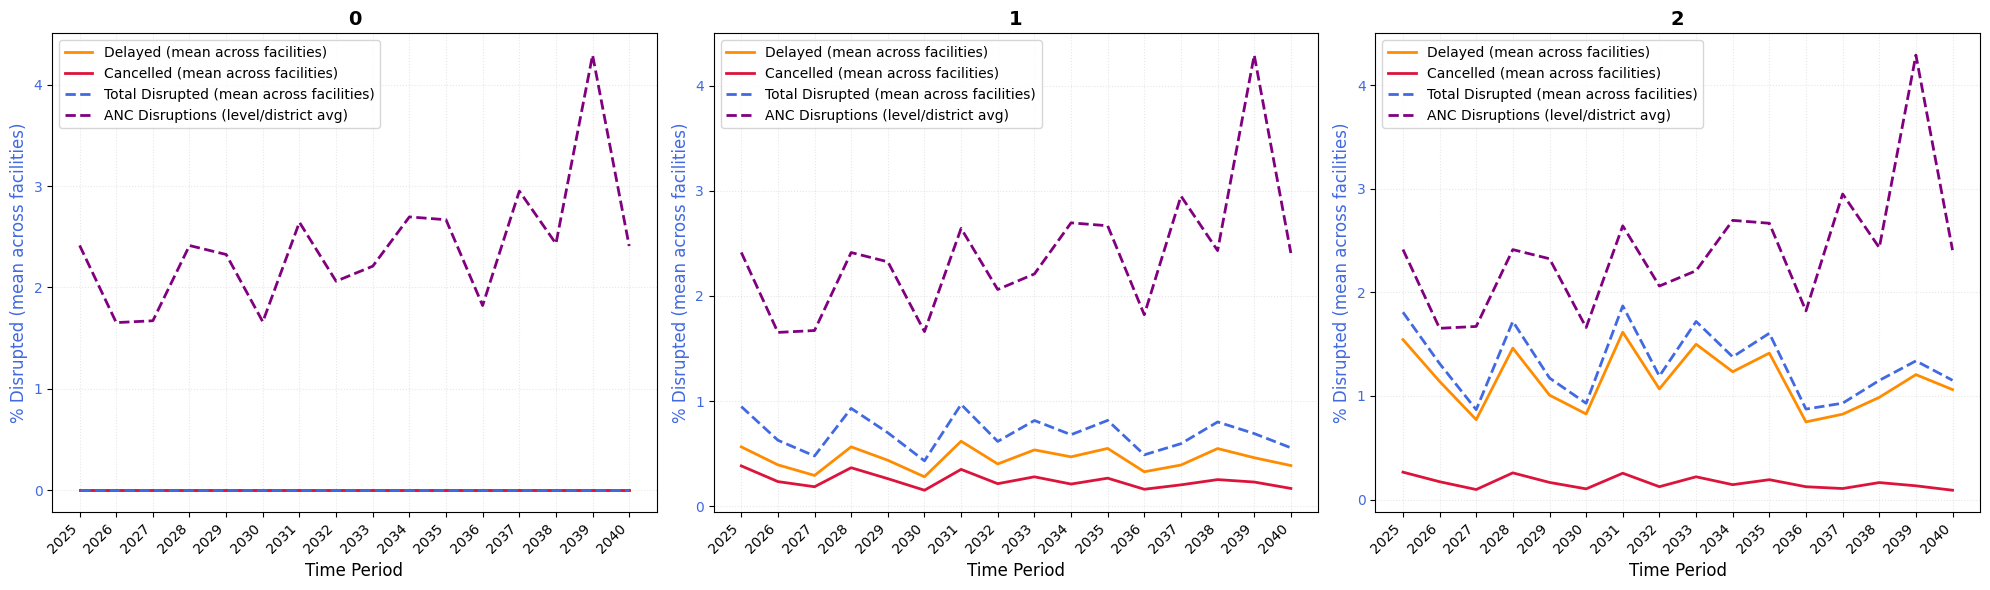

In [22]:
from collections import defaultdict
import re
# Now create the plots with dual y-axes
appointment_delayed_scenarios = {}
appointment_cancelled_scenarios = {}
daly_scenarios = {}

for draw in range(len(scenarios_of_interest)):

    delayed_by_scenario = all_scenarios_appointment_delayed_mean[draw]
    cancelled_by_scenario = all_scenarios_appointment_cancelled_mean[draw]
    daly_by_scenario = all_scenarios_dalys_mean[draw]

    # Now values are Series (by facility), so aggregate across facilities
    delayed_all_years = [delayed_by_scenario[year].mean() if isinstance(delayed_by_scenario[year], pd.Series) else delayed_by_scenario[year] 
                         for year in sorted(delayed_by_scenario.keys())]
    cancelled_all_years = [cancelled_by_scenario[year].mean() if isinstance(cancelled_by_scenario[year], pd.Series) else cancelled_by_scenario[year]
                           for year in sorted(cancelled_by_scenario.keys())]

    appointment_delayed_scenarios[draw] = delayed_all_years
    appointment_cancelled_scenarios[draw] = cancelled_all_years

scenario_names_filtered = list(appointment_delayed_scenarios.keys())

n_scenarios = len(scenario_names_filtered)
n_cols = min(3, n_scenarios)
n_rows = (n_scenarios + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
if n_scenarios == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]

for i, draw in enumerate(scenarios_of_interest):
    print(draw)
    ax1 = axes[i]

    delayed_data = np.array(appointment_delayed_scenarios[draw], dtype=float) * 100
    cancelled_data = np.array(appointment_cancelled_scenarios[draw], dtype=float) * 100
    total_data = delayed_data + cancelled_data

    # Get the years from your data
    years = sorted(all_scenarios_appointment_delayed_mean[draw].keys())
    start_date = pd.to_datetime([f'{y}-01-01' for y in years])
    
    # === Load ANC disruption data and process ===
    ssp = "ssp245"
    model = "mean"
    service = "ANC"
    
    
    # Load the facility-level predictions
    facility_df = pd.read_csv(
        f"/Users/rem76/Desktop/Climate_change_health/Data/"
        f"weather_predictions_with_X_{ssp}_{model}_{service}.csv"
    )
    
    # Define facility level mapping with comprehensive patterns
    facility_levels_types = {
        "level_0": [
            "Health Post",
            "Village Health Committee", 
            "Community Health Station",
            "Village Clinic",
            "Mobile Clinic",
            "Outreach Clinic",
            "Dispensary",
        ],
        "level_1a": [
            "Health Centre",
            "Rural Health Centre",
            "Urban Health Centre",
            "Clinic",
            "Private Clinic",
            "Special Clinic",
            "Antenatal Clinic",
            "Maternity Clinic",
            "Maternity Facility",
            "Medical Centre",
        ],
        "level_1b": [
            "Community Hospital",
            "Rural Hospital", 
            "CHAM Hospital",
            "Rural/Community Hospital",
            "Mission Hospital",
        ],
        "level_2": [
            "District Hospital",
            "District Health Office",
        ],
        "level_3": [
            "Kamuzu Central Hospital",
            "Mzuzu Central Hospital",
            "Zomba Central Hospital",
            "Queen Elizabeth Central Hospital",
            "Central Hospital",
        ],
        "level_4": [
            "Zomba Mental Hospital",
            "Mental Hospital",
            "Psychiatric Hospital",
        ],
    }

    # Create reverse lookup: FType -> Level
    ftype_to_level = {}
    for level, ftypes in facility_levels_types.items():
        for ftype in ftypes:
            ftype_to_level[ftype] = level
    
    # Store unmatched facilities for diagnostics
    unmatched_facilities = defaultdict(int)
    
    def map_facility_to_level(ftype, track_unmatched=True):
        """Map facility type to hierarchical level with improved fuzzy matching."""
        if pd.isna(ftype):
            return None
        
        # Direct match (case-sensitive first for speed)
        if ftype in ftype_to_level:
            return ftype_to_level[ftype]
        
        # Prepare for fuzzy matching
        ftype_lower = ftype.lower().strip()
        ftype_clean = re.sub(r'\s+', ' ', ftype_lower)  # Normalize whitespace
        
        # Fuzzy matching - ORDER MATTERS (most specific to most general)
        
        # Level 3: Central hospitals (must check before general "hospital")
        if any(term in ftype_clean for term in ['central hospital', 'referral hospital']):
            return 'level_3'
        
        # Level 4: Mental/Psychiatric hospitals
        if any(term in ftype_clean for term in ['mental hospital', 'psychiatric']):
            return 'level_4'
        
        # Level 2: District hospitals/offices
        if any(term in ftype_clean for term in ['district hospital', 'district health office']):
            return 'level_2'
        
        # Level 1b: Community/Rural/Mission hospitals
        if 'hospital' in ftype_clean:
            if any(term in ftype_clean for term in ['community', 'rural', 'cham', 'mission']):
                return 'level_1b'
            # Generic "hospital" without modifiers -> level_1b
            return 'level_1b'
        
        # Level 1a: Health centres and clinics
        if any(term in ftype_clean for term in ['health centre', 'health center']):
            return 'level_1a'
        
        if 'clinic' in ftype_clean:
            # Exclude "village clinic" which should be level_0
            if 'village' in ftype_clean or 'mobile' in ftype_clean or 'outreach' in ftype_clean:
                return 'level_0'
            return 'level_1a'
        
        # Level 0: Dispensaries, health posts, village facilities
        if any(term in ftype_clean for term in [
            'dispensary', 'health post', 'village', 'mobile', 'outreach',
            'community health station'
        ]):
            return 'level_0'
        
        # If we get here, no match found
        if track_unmatched:
            unmatched_facilities[ftype] += 1
        
        return None
    
    # Add Level column based on Facility_Type
    facility_df['Level'] = facility_df['Facility_Type'].apply(map_facility_to_level)

    # Remove rows with missing District or Level
    #facility_df = facility_df.dropna(subset=['District', 'Level'])
    #facility_df = facility_df.dropna(subset=['Difference_in_Expectation'])

    # Get simulation date range
    start_year = min_year
    start_month = 1
    end_year = max_year - 1
    end_month = 12
    
    # Filter to match simulation period
    facility_df = facility_df[
        ((facility_df["Year"] == start_year) & (facility_df["Month"] >= start_month)) |
        ((facility_df["Year"] > start_year) & (facility_df["Year"] < end_year)) |
        ((facility_df["Year"] == end_year) & (facility_df["Month"] <= end_month))
    ]
    facility_df = facility_df[facility_df['Difference_in_Expectation'] < 0]
    # Step 1: Group by Level, District, and Year
    # Sum the total predictions and disruptions for each Level/District/Year combination
    grouped = facility_df.groupby([ 'Level', 'District', 'Year'], as_index=False).agg({
        'Predicted_No_Weather_Model': 'sum',
        'Difference_in_Expectation': 'sum'
    })
    
    # Step 2: Calculate disruption percentage for each Level/District/Year
    grouped['Disruption_Pct'] = (
        grouped['Difference_in_Expectation'].abs() / 
        grouped['Predicted_No_Weather_Model']
    ) * 100
    

    # Step 3: Average disruption percentage across all Level/District combinations by Year
    avg_df = grouped.groupby('Year', as_index=False)['Disruption_Pct'].mean()
    avg_df = avg_df.sort_values('Year')
    
    # Extract values for plotting
    anc_disruption_values = avg_df['Disruption_Pct'].values
    
    # Plot appointment disruptions on primary y-axis
    line1 = ax1.plot(start_date, delayed_data, label="Delayed (mean across facilities)", linewidth=2, color='#FF8C00')
    line2 = ax1.plot(start_date, cancelled_data, label="Cancelled (mean across facilities)", linewidth=2, color='#DC143C')
    line3 = ax1.plot(start_date, total_data, label="Total Disrupted (mean across facilities)", linewidth=2, color='#4169E1', linestyle='--')
    
    line4 = ax1.plot(start_date, anc_disruption_values, label="ANC Disruptions (level/district avg)", linewidth=2, color='purple', linestyle='--')

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.xaxis.set_major_locator(mdates.YearLocator())
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

    ax1.set_xlabel("Time Period", fontsize=12)
    ax1.set_ylabel("% Disrupted (mean across facilities)", fontsize=12, color='#4169E1')
    ax1.tick_params(axis='y', labelcolor='#4169E1')
    ax1.set_title(f"{draw}", fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, linestyle=':')

    # Combine legends
    lines = line1 + line2 + line3 + line4
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best', fontsize=10)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
#plt.savefig(output_folder / f"delayed_cancelled_dalys.png", dpi=300, bbox_inches='tight')
plt.show()

In [23]:
facility_df

,Year,Month,Facility_ID,Altitude,Zone,District,Resid,Owner,Facility_Type,Precipitation,Lag_1_Precipitation,Lag_2_Precipitation,Lag_3_Precipitation,Lag_4_Precipitation,Predicted_Weather_Model,Predicted_No_Weather_Model,Difference_in_Expectation,Level
0,2025,1,Area 30 Police Clinic,1099.0,Central West,Lilongwe,Urban,Government,Clinic,304.534558,143.416463,32.817041,0.000000,3.635173,500.846109,526.139678,-25.293569,level_1a
1,2025,1,Balaka District Hospital,632.0,South East,Balaka,Urban,Government,District Hospital,420.246115,177.214102,88.948174,5.403880,0.000000,478.785819,511.563356,-32.777537,level_2
5,2025,1,Bolero Rural Hospital,1093.0,Northern,Rumphi,Urban,Government,Rural/Community Hospital,343.208875,221.636564,87.514934,6.052512,30.050557,281.157410,286.787483,-5.630072,level_1b
6,2025,1,Bondo Health Centre,678.0,South East,Mulanje,Rural,Government,Health Centre,432.038483,218.033633,66.554375,34.324290,20.608490,110.175225,121.093844,-10.918619,level_1a
8,2025,1,Bulala Health Centre,1263.0,Northern,Mzimba South,Rural,Government,Health Centre,270.176596,121.588573,29.127008,1.008181,24.248102,81.650914,82.605313,-0.954399,level_1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63155,2040,12,Tembwe Health Centre,1102.0,Central West,Mchinji,Rural,Government,Health Centre,212.060311,97.001482,9.655825,2.646626,0.000000,161.342219,164.708785,-3.366566,level_1a
63156,2040,12,Thekerani Rural Hospital,648.0,South West,Thyolo,Rural,Government,Rural/Community Hospital,163.184534,105.068313,33.439503,11.680109,19.762159,142.032395,144.690819,-2.658424,level_1b
63160,2040,12,Thumbwe Health Centre,811.0,South West,Chiradzulu,Rural,Government,Health Centre,235.229328,142.292396,21.119664,24.124978,19.078638,131.689498,138.157593,-6.468095,level_1a
63162,2040,12,Thyolo District Hospital,934.0,South West,Thyolo,Urban,Government,District Hospital,186.204871,117.556813,55.676225,17.362110,24.018567,426.888371,442.607183,-15.718812,level_2


Add in months

In [ ]:
results_folder_baseline = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/baseline_run_with_pop-2026-02-05T113912Z')


# Helper functions
def get_hsi_counts_by_facility_monthly(_df):
    """Get HSI counts by facility_id and month - returns with month as part of index"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]

    if len(_df) == 0:
        return pd.Series(dtype=int)

    # Create keys like "2010-01_128" (YYYY-MM_facilityID)
    facility_month_totals = {}
    for _, row in _df.iterrows():
        month_key = row['date'].strftime('%Y-%m')
        counts_dict = row['counts']

        for key, value in counts_dict.items():
            if ':' in key:
                facility_id, _ = key.split(':', 1)
                combined_key = f"{month_key}_{facility_id}"
                facility_month_totals[combined_key] = facility_month_totals.get(combined_key, 0) + value

    return pd.Series(facility_month_totals)


def get_num_treatments_by_facility_delayed(_df):
    """Count number of delayed HSI events by facility and month"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="delayed_count")
    
    # Extract month from date
    _df['month'] = _df['date'].dt.strftime('%Y-%m')
    
    # Create combined key: month_facilityID
    _df['month_facility'] = _df['month'] + '_' + _df['Facility_ID'].astype(str)
    
    # Group by month_facility and count
    delayed_by_month_facility = _df.groupby('month_facility').size()
    delayed_by_month_facility.name = 'delayed_count'
    
    return delayed_by_month_facility


def get_num_treatments_by_facility_cancelled(_df):
    """Count number of cancelled HSI events by facility and month"""
    _df["date"] = pd.to_datetime(_df["date"])
    _df = _df.loc[_df["date"].between(*TARGET_PERIOD)]
    
    if len(_df) == 0:
        return pd.Series(dtype=int, name="cancelled_count")
    
    # Extract month from date
    _df['month'] = _df['date'].dt.strftime('%Y-%m')
    
    # Create combined key: month_facilityID
    _df['month_facility'] = _df['month'] + '_' + _df['Facility_ID'].astype(str)
    
    # Group by month_facility and count
    cancelled_by_month_facility = _df.groupby('month_facility').size()
    cancelled_by_month_facility.name = 'cancelled_count'
    
    return cancelled_by_month_facility


# Storage dictionaries
all_scenarios_appointment_delayed_mean = {}
all_scenarios_appointment_cancelled_mean = {}
all_scenarios_dalys_mean = {}
scenarios_of_interest = range(3)

# Main loop
for draw in range(len(scenarios_of_interest)):
    print(draw)
    all_years_data_delayed_mean = {}
    all_years_data_cancelled_mean = {}
    all_years_dalys_mean = {}
    baseline_hsi_by_month_facility = {}
    
    for target_year in target_year_sequence:
        TARGET_PERIOD = (Date(target_year, 1, 1), Date(target_year, 12, 31))

        # Get baseline HSI by month and facility (format: "YYYY-MM_facilityID")
        hsi_by_month_facility = summarize(extract_results(
            results_folder_baseline,
            module='tlo.methods.healthsystem.summary',
            key='hsi_event_counts_by_facility_monthly',
            custom_generate_series=get_hsi_counts_by_facility_monthly,
            do_scaling=False
        ), only_mean=True, collapse_columns=False)[draw]

        baseline_hsi_by_month_facility[target_year] = hsi_by_month_facility

        if draw in [0]:
            all_years_data_delayed_mean[target_year] = pd.Series([0], name='mean')
            all_years_data_cancelled_mean[target_year] = pd.Series([0], name='mean')
        else:
            # Get delayed counts BY MONTH AND FACILITY
            num_delayed_by_month_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_delayed_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_delayed,
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Get cancelled counts BY MONTH AND FACILITY
            num_cancelled_by_month_facility = summarize(extract_results(
                results_folder_baseline,
                module='tlo.methods.healthsystem.summary',
                key='Weather_cancelled_HSI_Event_full_info',
                custom_generate_series=get_num_treatments_by_facility_cancelled,
                do_scaling=False
            ), only_mean=True, collapse_columns=False)[draw]

            # Align and calculate proportions at month-facility level
            baseline_aligned, delayed_aligned = baseline_hsi_by_month_facility[target_year].align(
                num_delayed_by_month_facility, fill_value=0
            )
            delayed_proportions = delayed_aligned / baseline_aligned
            
            baseline_aligned, cancelled_aligned = baseline_hsi_by_month_facility[target_year].align(
                num_cancelled_by_month_facility, fill_value=0
            )
            cancelled_proportions = cancelled_aligned / baseline_aligned
            
            all_years_data_delayed_mean[target_year] = delayed_proportions
            all_years_data_cancelled_mean[target_year] = cancelled_proportions

    all_scenarios_appointment_delayed_mean[draw] = all_years_data_delayed_mean
    all_scenarios_appointment_cancelled_mean[draw] = all_years_data_cancelled_mean
    all_scenarios_dalys_mean[draw] = all_years_dalys_mean

# DELETE IF NEEDED

In [47]:
from pathlib import Path

# Directory to clean
base_dir = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

# Find all .log files with specific name
all_log_files = list(base_dir.rglob('*.pickle'))
log_files = [f for f in all_log_files if f.name == 'tlo.methods.healthsystem.summary.pickle']

print(f"Found {len(all_log_files)} total .log files")
print(f"Found {len(log_files)} files named 'tlo.methods.healthsystem.summary.pickle'")

# Show first 10 as preview
print("\nFirst 10 files to be deleted:")
for i, log_file in enumerate(log_files[:10]):
    print(f"  {i+1}. {log_file.relative_to(base_dir)}")

if len(log_files) > 10:
    print(f"  ... and {len(log_files) - 10} more")

# Ask for confirmation
print(f"\n{'='*60}")
response = input(f"Delete all {len(log_files)} 'tlo.methods.healthsystem.pickle' files? (yes/no): ")

if response.lower() == 'yes':
    deleted = 0
    errors = 0
    
    for log_file in log_files:
        try:
            log_file.unlink()
            deleted += 1
            if deleted % 50 == 0:
                print(f"Deleted {deleted}/{len(log_files)} files...")
        except Exception as e:
            print(f"Error deleting {log_file}: {e}")
            errors += 1
    
    print(f"\n{'='*60}")
    print(f"Deletion complete!")
    print(f"  Deleted: {deleted}")
    print(f"  Errors: {errors}")
    print(f"{'='*60}")
else:
    print("Deletion cancelled")

Found 1006 total .log files
Found 191 files named 'tlo.methods.healthsystem.summary.pickle'

First 10 files to be deleted:
  1. 135/0/tlo.methods.healthsystem.summary.pickle
  2. 61/0/tlo.methods.healthsystem.summary.pickle
  3. 95/0/tlo.methods.healthsystem.summary.pickle
  4. 132/0/tlo.methods.healthsystem.summary.pickle
  5. 59/0/tlo.methods.healthsystem.summary.pickle
  6. 92/0/tlo.methods.healthsystem.summary.pickle
  7. 66/0/tlo.methods.healthsystem.summary.pickle
  8. 104/0/tlo.methods.healthsystem.summary.pickle
  9. 50/0/tlo.methods.healthsystem.summary.pickle
  10. 68/0/tlo.methods.healthsystem.summary.pickle
  ... and 181 more

Deletion cancelled


In [ ]:
from pathlib import Path

# Directory to clean
base_dir = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

# Find all .log files with specific name
all_log_files = list(base_dir.rglob('*.log'))
log_files = [f for f in all_log_files if f.name == 'tlo.methods.healthsystem.log']

print(f"Found {len(all_log_files)} total .log files")
print(f"Found {len(log_files)} files named 'tlo.methods.healthsystem.log'")

# Show first 10 as preview
print("\nFirst 10 files to be deleted:")
for i, log_file in enumerate(log_files[:10]):
    print(f"  {i+1}. {log_file.relative_to(base_dir)}")

if len(log_files) > 10:
    print(f"  ... and {len(log_files) - 10} more")

# Ask for confirmation
print(f"\n{'='*60}")
response = input(f"Delete all {len(log_files)} 'tlo.methods.healthsystem.log' files? (yes/no): ")

if response.lower() == 'yes':
    deleted = 0
    errors = 0
    
    for log_file in log_files:
        try:
            log_file.unlink()
            deleted += 1
            if deleted % 50 == 0:
                print(f"Deleted {deleted}/{len(log_files)} files...")
        except Exception as e:
            print(f"Error deleting {log_file}: {e}")
            errors += 1
    
    print(f"\n{'='*60}")
    print(f"Deletion complete!")
    print(f"  Deleted: {deleted}")
    print(f"  Errors: {errors}")
    print(f"{'='*60}")
else:
    print("Deletion cancelled")

In [46]:
from pathlib import Path

# Directory to clean
base_dir = Path('/Users/rem76/PycharmProjects/TLOmodel/outputs/rm916@ic.ac.uk/climate_scenario_runs_lhs_param_scan-2026-02-03T101537Z')

# Find all .log files that start with the specified prefix
all_log_files = list(base_dir.rglob('*.log'))
log_files = [f for f in all_log_files if f.name.startswith('climate_scenario_runs_lhs_param_scan__')]

print(f"Found {len(all_log_files)} total .log files")
print(f"Found {len(log_files)} files starting with 'climate_scenario_runs_lhs_param_scan__'")

# Show first 10 as preview
print("\nFirst 10 files to be deleted:")
for i, log_file in enumerate(log_files[:10]):
    print(f"  {i+1}. {log_file.relative_to(base_dir)}")

if len(log_files) > 10:
    print(f"  ... and {len(log_files) - 10} more")

# Ask for confirmation
print(f"\n{'='*60}")
response = input(f"Delete all {len(log_files)} 'climate_scenario_runs_lhs_param_scan__*.log' files? (yes/no): ")

if response.lower() == 'yes':
    deleted = 0
    errors = 0
    
    for log_file in log_files:
        try:
            log_file.unlink()
            deleted += 1
            if deleted % 50 == 0:
                print(f"Deleted {deleted}/{len(log_files)} files...")
        except Exception as e:
            print(f"Error deleting {log_file}: {e}")
            errors += 1
    
    print(f"\n{'='*60}")
    print(f"Deletion complete!")
    print(f"  Deleted: {deleted}")
    print(f"  Errors: {errors}")
    print(f"{'='*60}")
else:
    print("Deletion cancelled")

Found 1373 total .log files
Found 47 files starting with 'climate_scenario_runs_lhs_param_scan__'

First 10 files to be deleted:
  1. 135/0/climate_scenario_runs_lhs_param_scan__2026-02-03T102038.log
  2. 68/0/climate_scenario_runs_lhs_param_scan__2026-02-03T102114.log
  3. 56/0/climate_scenario_runs_lhs_param_scan__2026-02-03T102129.log
  4. 133/0/climate_scenario_runs_lhs_param_scan__2026-02-03T102107.log
  5. 67/0/climate_scenario_runs_lhs_param_scan__2026-02-03T102200.log
  6. 93/0/climate_scenario_runs_lhs_param_scan__2026-02-03T102200.log
  7. 134/0/climate_scenario_runs_lhs_param_scan__2026-02-03T102048.log
  8. 60/0/climate_scenario_runs_lhs_param_scan__2026-02-03T102218.log
  9. 158/0/climate_scenario_runs_lhs_param_scan__2026-02-03T102014.log
  10. 167/0/climate_scenario_runs_lhs_param_scan__2026-02-03T102019.log
  ... and 37 more


Deletion complete!
  Deleted: 47
  Errors: 0
